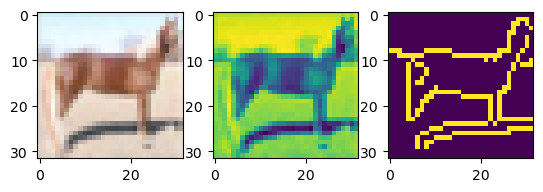

In [2]:
import cv2
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

a=Image.open('/kaggle/input/ml2021-hw11/real_or_drawing/train_data/0/0.bmp')
#original image
plt.subplot(1,3,1)
plt.imshow(a)
#gray-scale image
a=transforms.Grayscale()(a)
plt.subplot(1,3,2)
plt.imshow(a)
#Canny doesn't support RGB images
#canny image
a=cv2.Canny(np.array(a),170,300)
plt.subplot(1,3,3)
plt.imshow(a)
plt.show()



In [3]:
from torchvision.datasets import ImageFolder
import torch
from torch.utils.data import DataLoader

train_tfm=transforms.Compose([
    #to gray-scale,1 channel
    transforms.Grayscale(),
    transforms.Lambda(lambda x:cv2.Canny(np.array(x),170,300)),
    #numpy x
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15,fill=(0,)),
    transforms.ToTensor(),
])

target_tfm=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15,fill=(0,)),
    transforms.ToTensor(),
])

test_tfm=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set=ImageFolder("/kaggle/input/drawing-real/real_or_drawing/train_data",transform=train_tfm)
target_set=ImageFolder("/kaggle/input/drawing-real/real_or_drawing/test_data",transform=target_tfm)
test_set=ImageFolder("/kaggle/input/drawing-real/real_or_drawing/test_data",transform=test_tfm)

train_loader=DataLoader(train_set,batch_size=32,shuffle=True)
target_loader=DataLoader(target_set,batch_size=32,shuffle=True)
test_loader=DataLoader(test_set,batch_size=128,shuffle=False)

In [7]:
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(1,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
    def forward(self,x):
        return torch.squeeze(torch.squeeze(self.conv(x),dim=2),dim=2)

class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(512,512),
            nn.ReLU(),
            
            nn.Linear(512,512),
            nn.ReLU(),
            
            nn.Linear(512,10),
        )
    def forward(self,x):
        return self.layers(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )
    def forward(self,x):
        return torch.squeeze(self.layers(x),dim=1)
    
extractor=FeatureExtractor().to('cuda')
predictor=Predictor().to('cuda')
discriminator=Discriminator().to('cuda')

In [8]:
import torch.optim as optim

e_optimizer=optim.Adam(extractor.parameters(),lr=0.001)
p_optimizer=optim.Adam(predictor.parameters(),lr=0.001)
d_optimizer=optim.Adam(discriminator.parameters(),lr=0.001)

criterion_pred=nn.CrossEntropyLoss()
criterion_dis=nn.BCEWithLogitsLoss()

epoch=300

pred_loss_list=[]
domain_loss_list=[]
acc_list=[]

for i in range(epoch):
    lamb = np.log(1.05 + 1.7*i/epoch)
    pred_loss_=0.0
    domain_loss_=0.0
    acc=0.0
    for _,(train_data,target_data) in enumerate(zip(train_loader,target_loader)):
        
        train_images,train_labels=train_data
        train_images=train_images.to('cuda')
        train_labels=train_labels.to('cuda')
        
        target_images,_=target_data
        target_images=target_images.to('cuda')
        
        #mix source data with target data
        domain_data=torch.cat([train_images,target_images],dim=0)
        domain_labels=torch.zeros([len(train_images)+len(target_images)]).to('cuda')
        #set source data's domain label as 1
        domain_labels[:len(train_images)]=1
        
        feature=extractor(domain_data)
        
        #update domain classifier 
        domain_output=discriminator(feature.detach())
        domain_loss=criterion_dis(domain_output,domain_labels)
        domain_loss_+=domain_loss.item()
        
        domain_loss.backward()
        d_optimizer.step()
        
        
        output=predictor(feature[:len(train_images)])
        acc+=torch.sum(torch.argmax(output, dim=1) ==train_labels).item()
        pred_loss=criterion_pred(output,train_labels)
        pred_loss_+=pred_loss.item()
        
        #update label predictor and feature extractor
        loss=pred_loss-lamb*criterion_dis(discriminator(feature),domain_labels)
        loss.backward()
        e_optimizer.step()
        p_optimizer.step()
        
        d_optimizer.zero_grad()
        e_optimizer.zero_grad()
        p_optimizer.zero_grad()
    
    domain_loss_/=len(train_loader)
    domain_loss_list.append(domain_loss_)
    pred_loss_/=len(train_loader)
    pred_loss_list.append(pred_loss_)
    acc/=32*len(train_loader)        
    acc_list.append(acc)
    print('epoch',i+1,'domain_loss',domain_loss_,'pred_loss',pred_loss_,'acc',acc)

epoch 1 domain_loss 0.5952572107884535 pred_loss 1.9252280915618702 acc 0.2914012738853503
epoch 2 domain_loss 0.5473150375542367 pred_loss 1.5828259917581158 acc 0.4482484076433121
epoch 3 domain_loss 0.4811250888238287 pred_loss 1.4696747565725048 acc 0.4850716560509554
epoch 4 domain_loss 0.4909908621554162 pred_loss 1.40610879469829 acc 0.5081608280254777
epoch 5 domain_loss 0.4984369372865956 pred_loss 1.3413341170663287 acc 0.5256767515923567
epoch 6 domain_loss 0.49013415168804725 pred_loss 1.305364339214981 acc 0.5445859872611465
epoch 7 domain_loss 0.5093988028301555 pred_loss 1.2491583600165739 acc 0.5565286624203821
epoch 8 domain_loss 0.5149194353325351 pred_loss 1.2256481320994674 acc 0.5728503184713376
epoch 9 domain_loss 0.5228963536062058 pred_loss 1.1928971390815297 acc 0.575437898089172
epoch 10 domain_loss 0.5159389993567376 pred_loss 1.1420839117590789 acc 0.5911624203821656
epoch 11 domain_loss 0.5206581714806283 pred_loss 1.1235662861994118 acc 0.6108678343949044


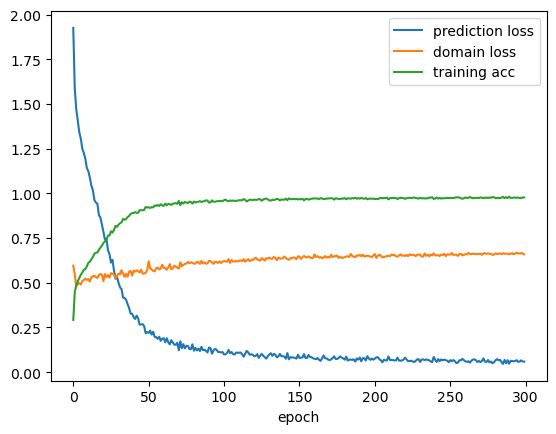

In [13]:
x=range(300)
fig,ax=plt.subplots()
ax.plot(x,pred_loss_list,label='prediction loss')
ax.plot(x,domain_loss_list,label='domain loss')
ax.plot(x,acc_list,label='training acc')
ax.set_xlabel("epoch")
ax.legend()
plt.show()


In [14]:
#predict labels of the test data
result = []
predictor.eval()
extractor.eval()
for i, (test_data, _) in enumerate(test_loader):
    test_data = test_data.cuda()

    class_logits =predictor(extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)